In [4]:
#importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.utils import shuffle
random_state = 12345
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.linear_model import CoxPHSurvivalAnalysis

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import KFold, GridSearchCV
np.random.seed(5)


. Data preprocessing:

1. Handeling the categorical data by getdumies, then converting false and True to 0 and 1\
2. Taking a random raadot of every vehicle
2. Merging all three files
3. Handeling the missing values by bfilna
4. Feature enginering, 
    thoese corrolated with each other with threashold 0.95
    and those not corrolated with RUL less than 0.01, are removed.



In [5]:
# Read data from three files
X_train = pd.read_csv("IDA_2024/train_operational_readouts.csv")
X_train_spec = pd.read_csv("IDA_2024/train_specifications.csv")
X_train_tte = pd.read_csv("IDA_2024/train_tte.csv")


In [6]:
#Handeling categorical data
spec_encoded = pd.get_dummies(X_train_spec)
spec_encoded = spec_encoded.replace({False: 0, True: 1}) 
categorical_col = spec_encoded.columns[1:]
numerical_col = X_train.columns[2:]

C:\Users\moka6903\AppData\Local\Temp\7\ipykernel_19212\2659550071.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spec_encoded = spec_encoded.replace({False: 0, True: 1})


In [8]:
#  Random read out

np.random.seed(5)
random_readouts = X_train.groupby('vehicle_id').apply(lambda x: x.sample(1, random_state= random_state)).reset_index(drop=True)
X_train_rand_cycle = random_readouts 

C:\Users\moka6903\AppData\Local\Temp\7\ipykernel_19212\3970261928.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  random_readouts = X_train.groupby('vehicle_id').apply(lambda x: x.sample(1, random_state= random_state)).reset_index(drop=True)


In [9]:
# Merged validation train and validation lable
df_train = pd.merge(X_train_tte , X_train_rand_cycle , left_on='vehicle_id', right_on='vehicle_id')
dataset_merged=  pd.merge(df_train, spec_encoded , left_on='vehicle_id', right_on='vehicle_id')
#missing values
print('Missing value number =', dataset_merged.isna().sum().sum())

Missing value number = 7210


In [11]:
# Missing value is filled with their above row value by bfill
dataset_ffil = dataset_merged.bfill(axis = 0)
print('Missing value number after filling =', dataset_ffil.isna().sum().sum())

Missing value number after filling = 0


In [12]:
# Create status column
dataset_ffil['status'] = dataset_ffil['in_study_repair'].apply(lambda x: False if x == 0 else True)
# Distribution of each status
print('X_train value_counts',dataset_ffil['status'].value_counts())

X_train value_counts status
False    21278
True      2272
Name: count, dtype: int64


In [13]:
# Create RUL column
dataset_ffil['RUL'] = dataset_ffil['length_of_study_time_step'] - dataset_ffil['time_step']

In [14]:
target_column = 'RUL'
df = dataset_ffil[list(numerical_col) + list(categorical_col) + ['RUL']].copy()

In [15]:
# Compute the correlation matrix
correlation_matrix = df.corrwith(df[target_column]).abs()

# Filter out correlations below the threshold
threshold = 0.01
filtered_correlations = correlation_matrix[correlation_matrix.abs() <= threshold]
sorted_correlations = filtered_correlations.sort_values()
least_correlated_features = sorted_correlations.index.tolist()
# Print the least correlated features
print("Least correlated features:")
print(least_correlated_features)


Least correlated features:
['397_17', '397_11', 'Spec_2_Cat12', 'Spec_6_Cat13', 'Spec_1_Cat16', 'Spec_2_Cat7', 'Spec_1_Cat12', 'Spec_1_Cat10', 'Spec_1_Cat11', 'Spec_2_Cat11', 'Spec_1_Cat17', 'Spec_3_Cat0', 'Spec_1_Cat8', 'Spec_1_Cat25', 'Spec_1_Cat15', 'Spec_6_Cat6', 'Spec_6_Cat11', 'Spec_1_Cat6', 'Spec_3_Cat2', 'Spec_2_Cat18', 'Spec_6_Cat10', 'Spec_1_Cat26', '397_23', '397_29', 'Spec_6_Cat8', 'Spec_5_Cat4', 'Spec_3_Cat1', 'Spec_1_Cat19', 'Spec_6_Cat12', 'Spec_1_Cat14', 'Spec_1_Cat27', 'Spec_2_Cat9', 'Spec_5_Cat2', 'Spec_6_Cat17', 'Spec_2_Cat16', 'Spec_2_Cat20', 'Spec_6_Cat18', 'Spec_1_Cat20', 'Spec_2_Cat15', 'Spec_3_Cat3', 'Spec_6_Cat9', 'Spec_6_Cat15', 'Spec_2_Cat10', 'Spec_0_Cat2', 'Spec_1_Cat13', 'Spec_1_Cat21', 'Spec_1_Cat18', 'Spec_1_Cat22', '459_17', 'Spec_1_Cat4', 'Spec_6_Cat3', 'Spec_1_Cat23', 'Spec_2_Cat8', 'Spec_1_Cat7']


In [16]:
# drop features with least correlation with RUL
dataset_droped_corr = dataset_ffil.drop(columns= least_correlated_features, inplace = False, axis = 1)
dataset_droped_corr

vehicle_id  length_of_study_time_step  in_study_repair  time_step  \
0               0                      510.0                0      494.6   
1               2                      281.8                0      234.8   
2               3                      293.4                0      136.6   
3               4                      210.0                0      136.2   
4               5                      360.4                0      211.2   
...           ...                        ...              ...        ...   
23545       33639                      137.4                0       64.4   
23546       33640                      124.6                0      101.4   
23547       33641                      123.0                0       69.4   
23548       33642                      126.6                0      118.4   
23549       33643                      130.2                0      107.0   

           171_0     666_0        427_0    837_0    167_0      167_1  ...  \
0      9934035.0  362143.0  194933994.0  41212.0  10414.0  7603578.0  ...   
1      4665090.0  254502.0  194933994.0  52499.0  10414.0  7603578.0  ...   
2      3350040.0  107479.0  121704479.0  49106.0   6797.0  2209053.0  ...   
3      2925015.0  131096.0  105981880.0  93057.0   6797.0  2209053.0  ...   
4      3233430.0  179422.0  123151184.0  96030.0   2688.0  5683398.0  ...   
...          ...       ...          ...      ...      ...        ...  ...   
23545  1531335.0   36260.0   51412659.0   6640.0   5521.0  2596023.0  ...   
23546  3257265.0  115169.0  115036037.0  30956.0  15396.0  4682449.0  ...   
23547  1320795.0   80014.0   47283193.0   7306.0      0.0  2026082.0  ...   
23548  3161940.0   76017.0  111622889.0  10570.0    755.0  9063001.0  ...   
23549  2283285.0   44660.0   86639835.0  12317.0    843.0  6596477.0  ...   

       Spec_7_Cat1  Spec_7_Cat2  Spec_7_Cat3  Spec_7_Cat4  Spec_7_Cat5  \
0                0            0            0            0            0   
1                1            0            0            0            0   
2                1            0            0            0            0   
3                1            0            0            0            0   
4                1            0            0            0            0   
...            ...          ...          ...          ...          ...   
23545            0            0            0            1            0   
23546            0            0            0            1            0   
23547            0            0            0            1            0   
23548            0            0            0            1            0   
23549            0            0            0            1            0   

       Spec_7_Cat6  Spec_7_Cat7  Spec_7_Cat8  status    RUL  
0                0            0            0   False   15.4  
1                0            0            0   False   47.0  
2                0            0            0   False  156.8  
3                0            0            0   False   73.8  
4                0            0            0   False  149.2  
...            ...          ...          ...     ...    ...  
23545            0            0            0   False   73.0  
23546            0            0            0   False   23.2  
23547            0            0            0   False   53.6  
23548            0            0            0   False    8.2  
23549            0            0            0   False   23.2  

[23550 rows x 147 columns]

In [17]:

df2 = dataset_droped_corr.drop(columns= ['length_of_study_time_step', 'time_step', 'in_study_repair', 'vehicle_id', 'status','RUL'], axis = 1)

# Define the correlation threshold
correlation_threshold = 0.9
correlation_matrix = df2.corr().abs()
upper_triangle = np.triu(correlation_matrix, k=1)

# Find the indices where the correlation exceeds the threshold
high_correlation_indices = np.where(upper_triangle > correlation_threshold)

# Initialize a list to store pairs of highly correlated variables
high_correlation_pairs = []
high_correlation_features = []

# Iterate through the indices and extract the variable pairs
for i, j in zip(high_correlation_indices[0], high_correlation_indices[1]):
    variable_i = correlation_matrix.index[i]
    variable_j = correlation_matrix.columns[j]
    correlation_value = correlation_matrix.iloc[i, j]
    high_correlation_pairs.append((variable_i, variable_j, correlation_value))
    high_correlation_features.append(variable_i)

# Print the highly correlated variable pairs
print("Highly Correlated Variable:")
print( list(set(high_correlation_features)))
# drop on of the highly correlated feature pairs:
main_data1 = dataset_droped_corr.drop(columns= list(set(high_correlation_features)))

Highly Correlated Variable:
['291_0', '459_6', 'Spec_0_Cat0', '167_1', '291_9', '291_8', '459_7', '459_2', 'Spec_1_Cat28', 'Spec_4_Cat0', '427_0', '291_2', '291_4', '459_11', '158_6', '397_22', '835_0', '167_5', '459_9', 'Spec_1_Cat9', '397_28', '397_24', '459_3', '171_0', '158_4', '158_5', '459_8', '459_10', '167_2', '291_1', '291_5', '397_27', '459_5', '459_4', '397_20', '291_7', '291_6']


In [18]:
# preparing the final dataset that goes for split into train and test
main_data =main_data1.drop(columns= ['length_of_study_time_step', 'time_step', 'in_study_repair', 'vehicle_id'], axis = 1)
main_data

666_0    837_0    167_0       167_3       167_4       167_6  \
0      362143.0  41212.0  10414.0  39966681.0  55348562.0   5309527.0   
1      254502.0  52499.0  10414.0  39966681.0  55348562.0   5309527.0   
2      107479.0  49106.0   6797.0   5810370.0  15891167.0  30535744.0   
3      131096.0  93057.0   6797.0   5810370.0  15891167.0  30535744.0   
4      179422.0  96030.0   2688.0  13029110.0  37102774.0  13835527.0   
...         ...      ...      ...         ...         ...         ...   
23545   36260.0   6640.0   5521.0   5069147.0  13503561.0   4922342.0   
23546  115169.0  30956.0  15396.0   6196253.0  16163103.0  39373639.0   
23547   80014.0   7306.0      0.0   2662069.0   7600906.0   8476338.0   
23548   76017.0  10570.0    755.0   7459189.0  16856313.0   9132063.0   
23549   44660.0  12317.0    843.0   6721702.0  16509424.0  10741158.0   

           167_7    167_8    167_9   309_0  ...  Spec_7_Cat1  Spec_7_Cat2  \
0         3350.0      0.0      0.0   180.0  ...            0            0   
1         3350.0      0.0      0.0   591.0  ...            1            0   
2       915811.0   5928.0      0.0  5912.0  ...            1            0   
3       915811.0   5928.0      0.0   996.0  ...            1            0   
4       658881.0  43760.0  13999.0  6750.0  ...            1            0   
...          ...      ...      ...     ...  ...          ...          ...   
23545    27362.0      0.0      0.0   182.0  ...            0            0   
23546  1449979.0  50103.0      0.0  6051.0  ...            0            0   
23547    85188.0      0.0      0.0   159.0  ...            0            0   
23548   482356.0   2238.0      0.0   465.0  ...            0            0   
23549   878526.0  61755.0   1115.0  1443.0  ...            0            0   

       Spec_7_Cat3  Spec_7_Cat4  Spec_7_Cat5  Spec_7_Cat6  Spec_7_Cat7  \
0                0            0            0            0            0   
1                0            0            0            0            0   
2                0            0            0            0            0   
3                0            0            0            0            0   
4                0            0            0            0            0   
...            ...          ...          ...          ...          ...   
23545            0            1            0            0            0   
23546            0            1            0            0            0   
23547            0            1            0            0            0   
23548            0            1            0            0            0   
23549            0            1            0            0            0   

       Spec_7_Cat8  status    RUL  
0                0   False   15.4  
1                0   False   47.0  
2                0   False  156.8  
3                0   False   73.8  
4                0   False  149.2  
...            ...     ...    ...  
23545            0   False   73.0  
23546            0   False   23.2  
23547            0   False   53.6  
23548            0   False    8.2  
23549            0   False   23.2  

[23550 rows x 106 columns]

Split to train and test, 80/20

In [19]:
x_train, x_test, y_train, y_test = train_test_split(shuffle(main_data), main_data['status'], test_size=0.2, random_state= random_state,
                                                    stratify= main_data['status'])


Train X and Train y

In [20]:
# Preprocessing for target variable for train dataset
train_y = list(x_train.loc[:, ["status", "RUL"]].itertuples(index = None, name = None))
train_y = np.array(train_y, dtype=[('status', bool), ('RUL', float)])
train_X = x_train.drop(columns= ['RUL','status'], axis = 1)
train_X.shape

(18840, 104)

In [21]:
# Preprocessing for target variable for test dataset
test_y = list(x_test.loc[:, ["status", "RUL"]].itertuples(index = None, name = None))
test_y = np.array(test_y, dtype=[('status', bool), ('RUL', float)])
test_X = x_test.drop(columns= ['RUL','status'], axis = 1)
test_X.shape

(4710, 104)

. Modelling: 
 
 RSF 
 CPH 
 XGB
 SSVM
 Using kfold cross validation hyperparameter tunning
 
Cross validation

Cross validation Grid search for RSF

In [ ]:
# Cross validation with kfold Gridsearchcv 
# RSF

cv = KFold(n_splits = 5)

rfs_cv = RandomSurvivalForest(random_state=random_state, n_jobs=-1, max_features='log2')

params = {'n_estimators':[400, 100],
        'max_depth':[ 30, 15,20],
        'min_samples_split':[30 ,40, 50],
        'min_samples_leaf':[20, 10,30]
         }
grid_clf1 = GridSearchCV(#concordance_index_ipcw,
                         estimator = rfs_cv, param_grid = params, 
                         cv = cv, #n_iter = 5,
                         #n_jobs = -1,
                         verbose = 4)

grid_clf1.fit(train_X, train_y)

print(grid_clf1.best_params_) 
print('The best score of the selected model:', grid_clf1.best_score_)

In [22]:
#RandomSurvivalForest training
rsf = RandomSurvivalForest(
    n_estimators=100, max_depth= 30,  min_samples_split=30, min_samples_leaf=20, n_jobs = -1, random_state=random_state, max_features='log2'
)
rsf.fit(train_X, train_y)
print( 'rsf train_score = ', rsf.score(train_X, train_y))
print('rsf test_score =', rsf.score(test_X, test_y))

rsf train_score =  0.9321824283456103
rsf test_score = 0.7343591482002796


Cross validation Grid search for XGB

In [ ]:
cv = KFold(n_splits = 5)

GB_cv = GradientBoostingSurvivalAnalysis(random_state=random_state)

params = {'n_estimators':[100, 100, 200],
     'max_depth':[5, 1,6],
     'learning_rate':[0.5, 1, 0.1],
     'min_samples_split':[ 50, 30],
     'min_samples_leaf':[ 20, 5,10] 
         }


grid_clf2 = GridSearchCV(estimator = GB_cv, param_grid = params, 
                         cv = cv,  verbose = 4)
grid_clf2.fit(train_X, train_y)
print(grid_clf2.best_params_) 
print('The best score of the selected model:', grid_clf2.best_score_)

In [23]:
#GBSA training
GBSA = GradientBoostingSurvivalAnalysis(n_estimators=100,min_samples_split =50, min_samples_leaf =20,  learning_rate=0.5, max_depth=5, random_state=random_state)
GBSA.fit(train_X, train_y)

print('GBSA train_score = ',GBSA.score(train_X,train_y))
print('GBSA test_score = ',GBSA.score(test_X,test_y))

GBSA train_score =  0.8696066929561378
GBSA test_score =  0.7225657162649137


Cross validation Grid search for SSVM

In [ ]:
cv = KFold(n_splits = 5)

svm_cv = FastKernelSurvivalSVM(random_state=random_state)

params = {'kernel':['rbf', 'linear', 'sigmoid'],
     'alpha':[0, 3, 7, 10],
     'gamma':[ 0, 0.5, 1] 
         }


grid_clf3 = GridSearchCV(estimator = svm_cv, param_grid = params, 
                         cv = cv, #n_iter = 5,
                         #n_jobs = -1,
                         verbose = 4)

grid_clf3.fit(train_X, train_y)

print(grid_clf3.best_params_) 
print('The best score of the selected model:', grid_clf3.best_score_)

In [24]:
# SSVM training
svm = FastKernelSurvivalSVM(alpha=3,  gamma= 0, kernel='linear', degree=3, coef0=1, max_iter=20, random_state=random_state, timeit=False)

svm.fit(train_X, train_y)

print('SSVM_train_score', svm.score(train_X, train_y))
print( 'SSVM_test_score' ,svm.score(test_X, test_y))

SSVM_train_score 0.6142787505383788
SSVM_test_score 0.6077330785172521


In [25]:
# COXProportionalHazard
estimator = CoxPHSurvivalAnalysis()
estimator.fit(train_X, train_y)
print( 'Cox_test_score' ,estimator.score(test_X, test_y))
print('Cox_train_score' ,estimator.score(train_X, train_y))

\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=4.71765e-34): result may not be accurate.
  delta = solve(
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=6.92099e-109): result may not be accurate.
  delta = solve(
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:170: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\site-packages\sksurv\linear_model\coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.01377e-52): result may not be accurate.
  delta = solve(
\\GOOFY2\HT21\moka6903\Desktop\Code\venv\venv\Lib\si

Cox_test_score 0.7039613583531282
Cox_train_score 0.7178198955533294


SHAP

In [26]:
import shap
from sklearn.ensemble import RandomForestRegressor

X_testt = test_X
X_trainn = train_X

# Convert RandomSurvivalForest to a RandomForestRegressor (surrogate model)
# using the predicted survival times as the target variable
surrogate_model = RandomForestRegressor(n_estimators=100, max_depth= 30, max_features='log2',  min_samples_split=30, min_samples_leaf=20, n_jobs = -1, random_state=random_state)
surrogate_model.fit(X_trainn, rsf.predict(X_trainn))

# Create a SHAP explainer for the surrogate model
explainer = shap.Explainer(surrogate_model, X_trainn)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


100%|===================| 4700/4710 [03:05<00:00]        

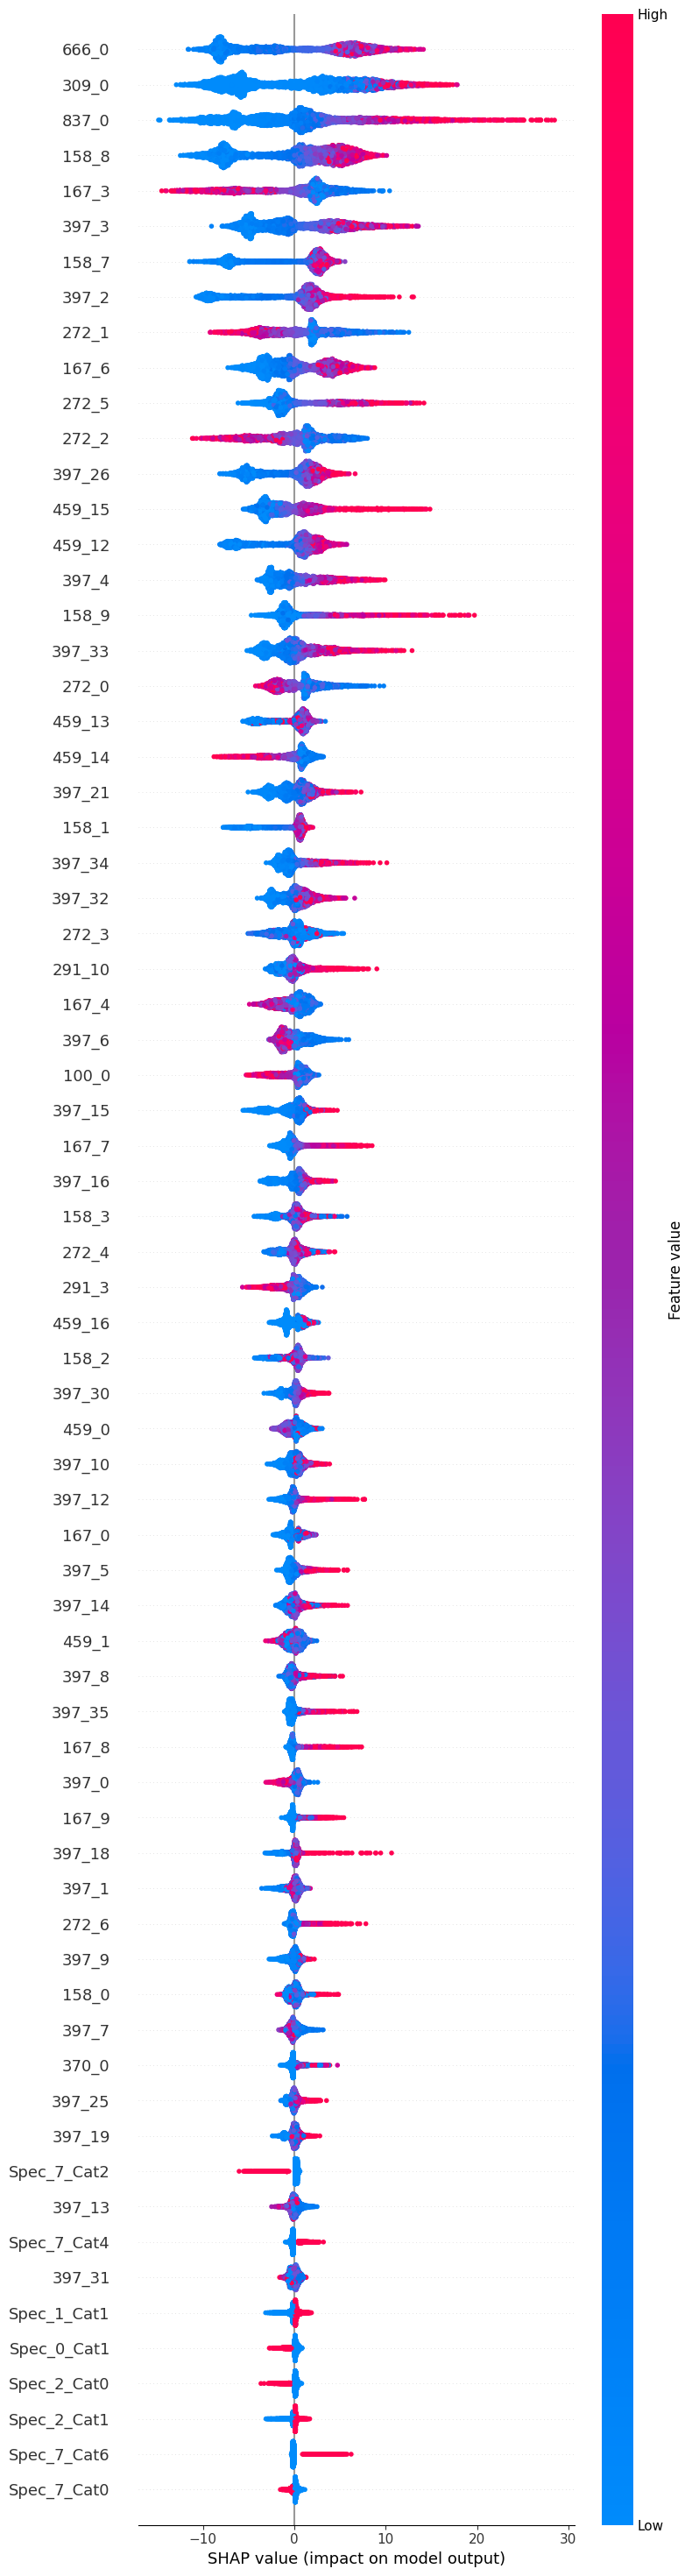

In [27]:
#Global Explanation
shap_values = explainer.shap_values(X_testt)
shap.summary_plot(shap_values, X_testt, max_display=70 )

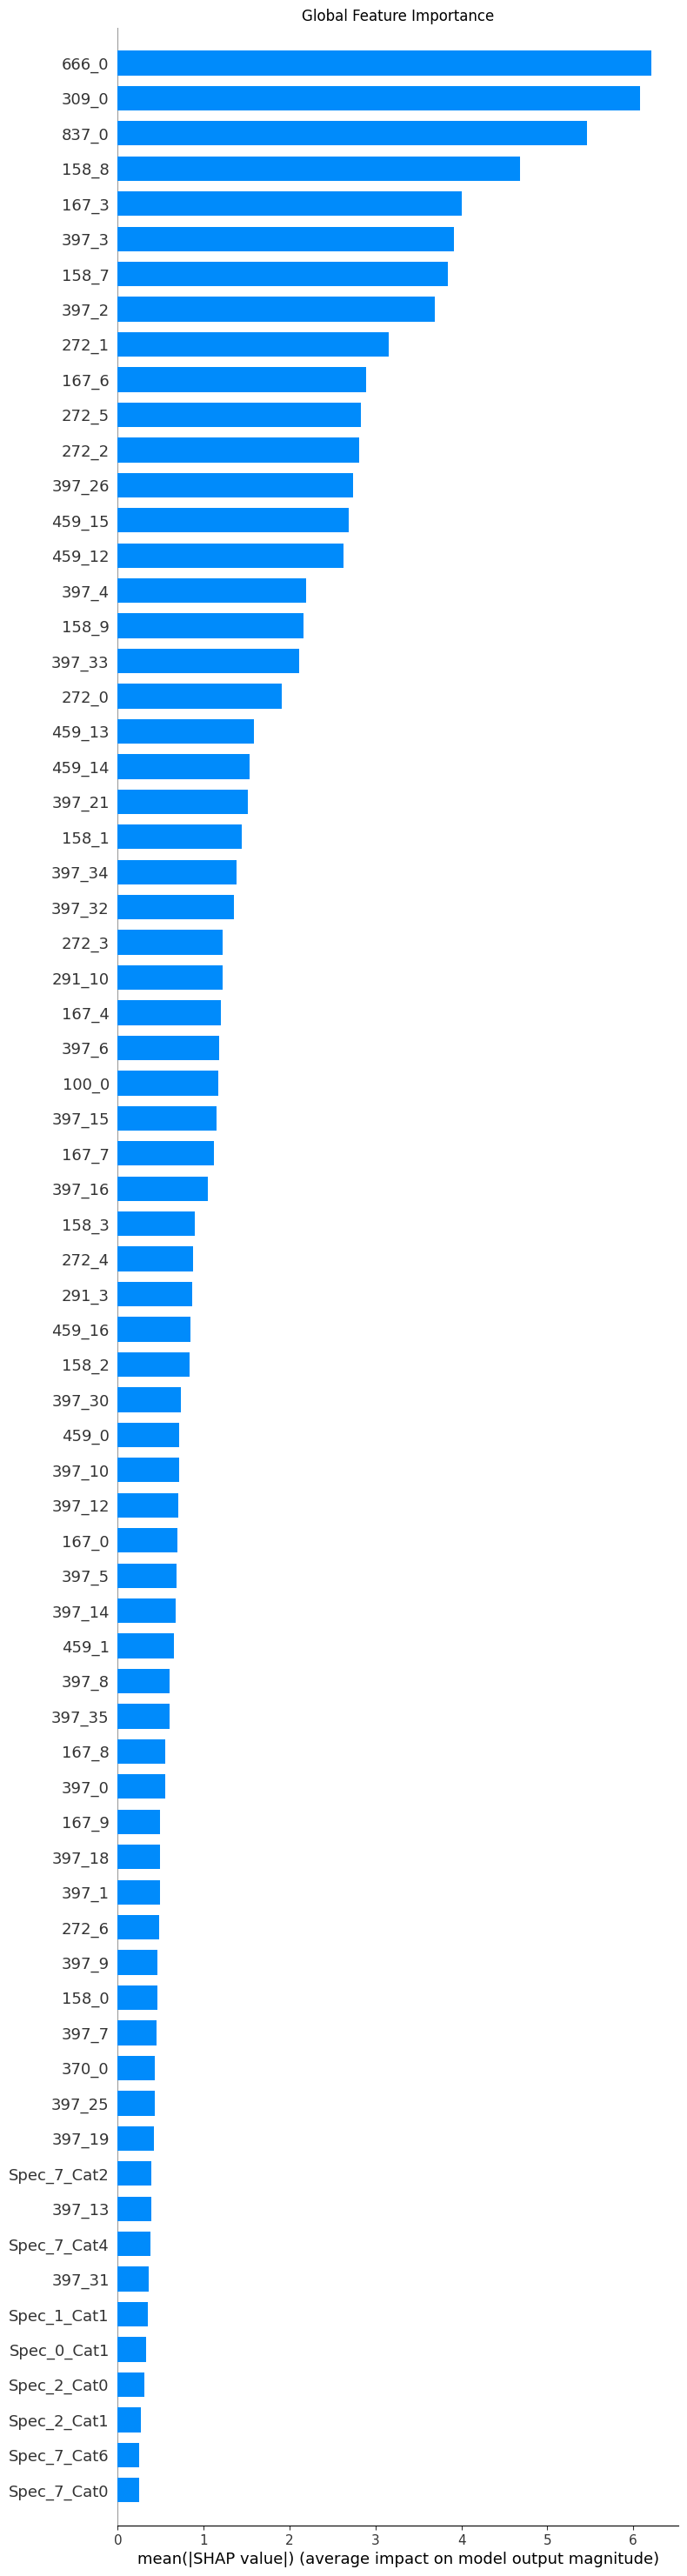

In [28]:
shap.summary_plot(shap_values, X_testt, plot_type='bar',max_display=70, show=False)
plt.title('Global Feature Importance')
plt.show()

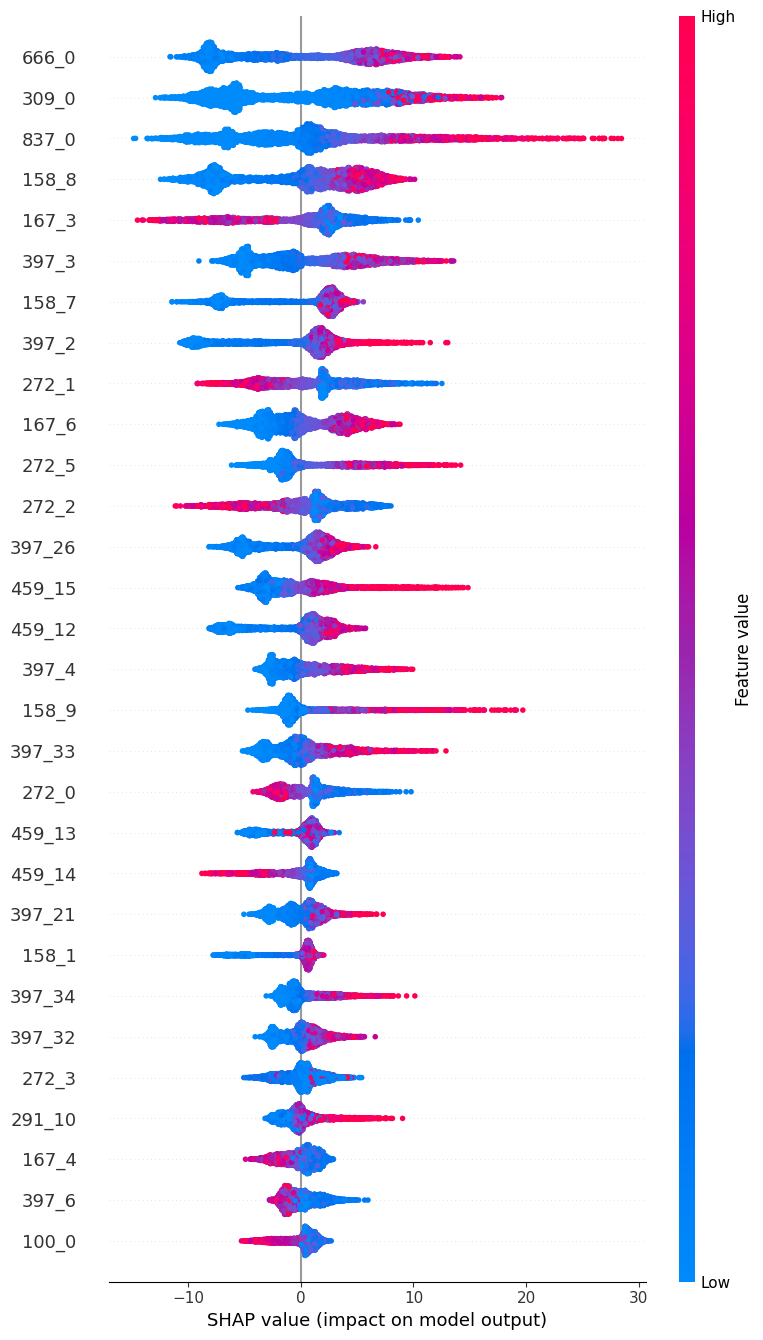

In [29]:
shap.summary_plot(shap_values, X_testt, max_display=30 )

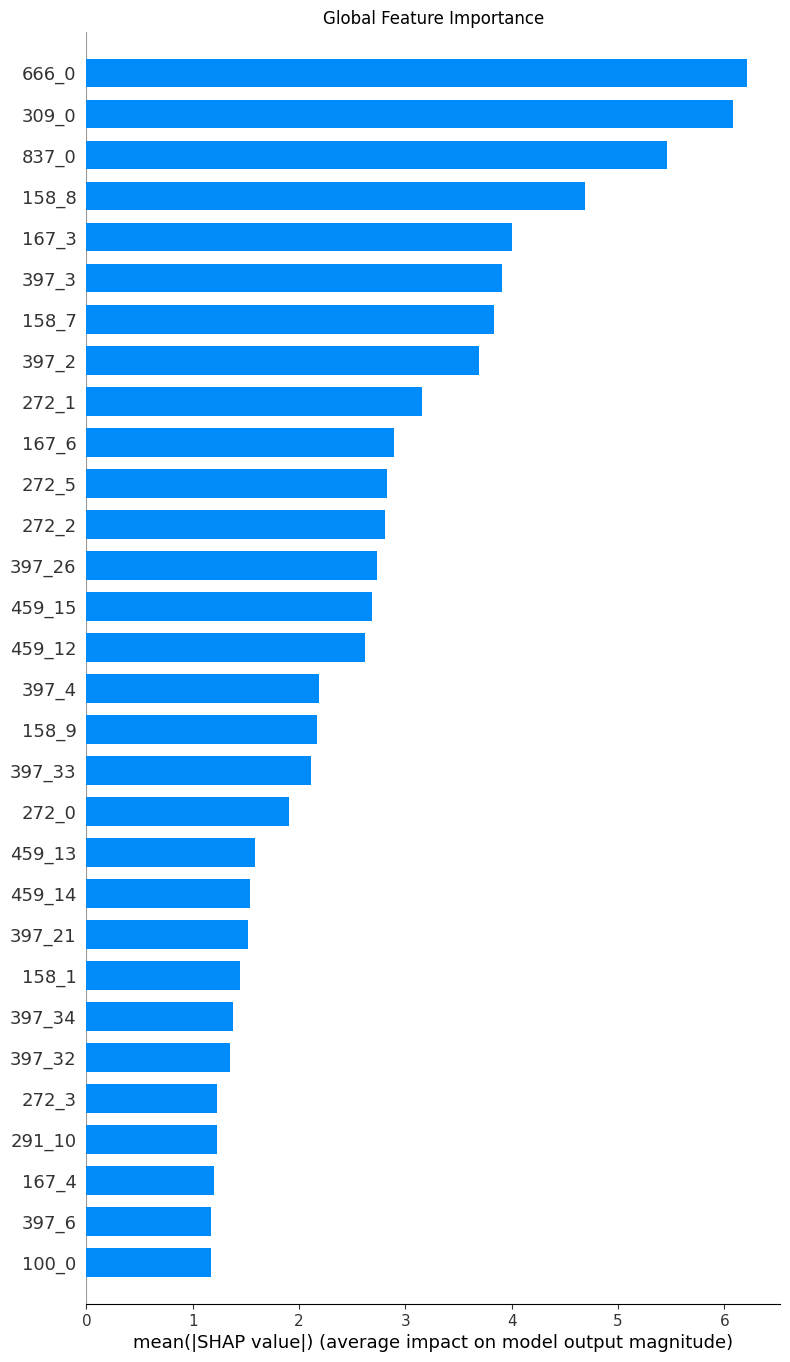

In [30]:
shap.summary_plot(shap_values, X_testt, plot_type='bar',max_display=30, show=False)
plt.title('Global Feature Importance')
plt.show()

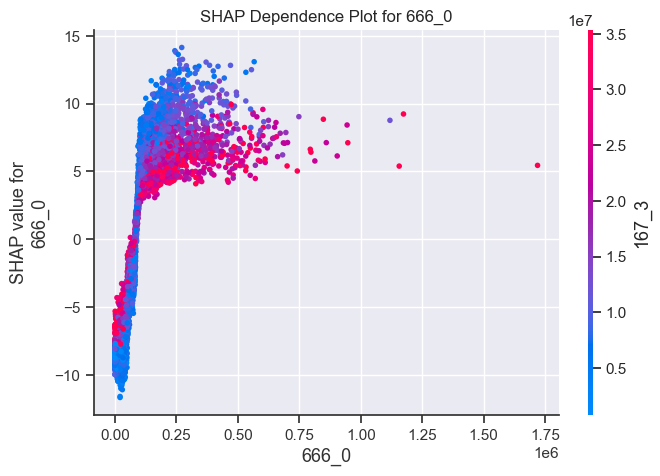

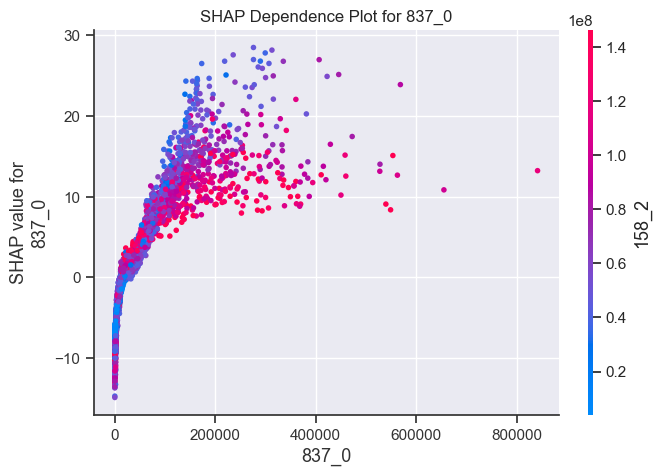

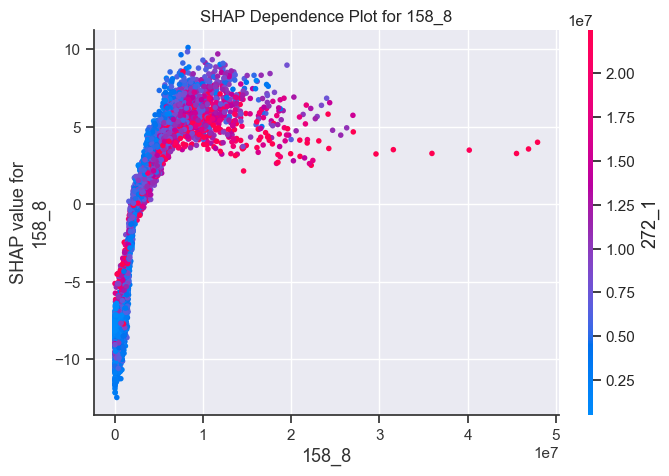

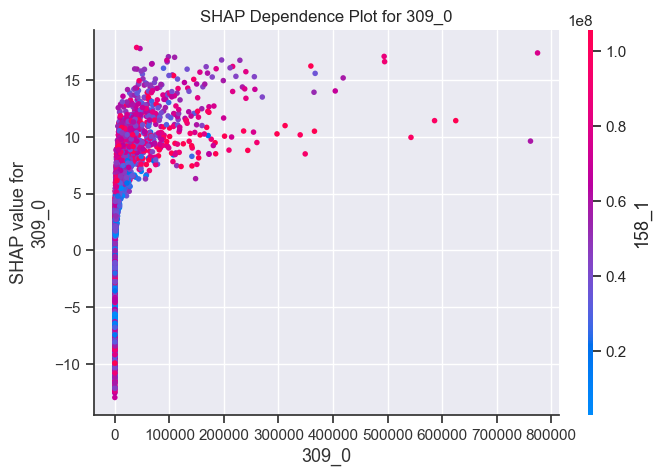

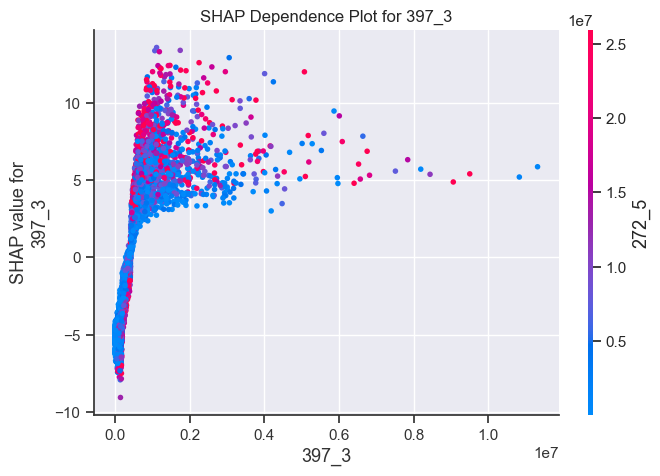

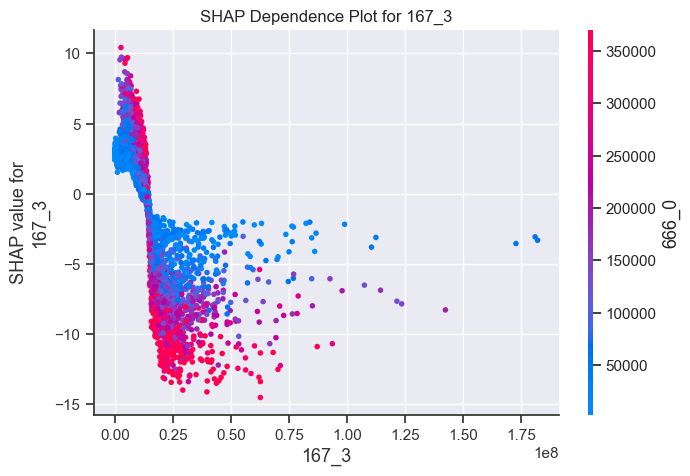

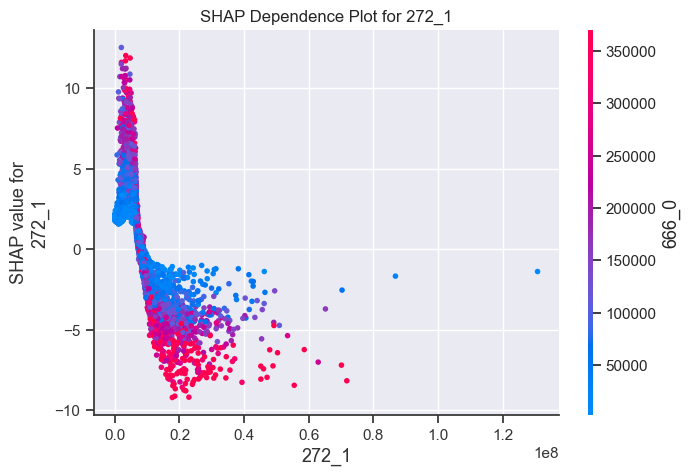

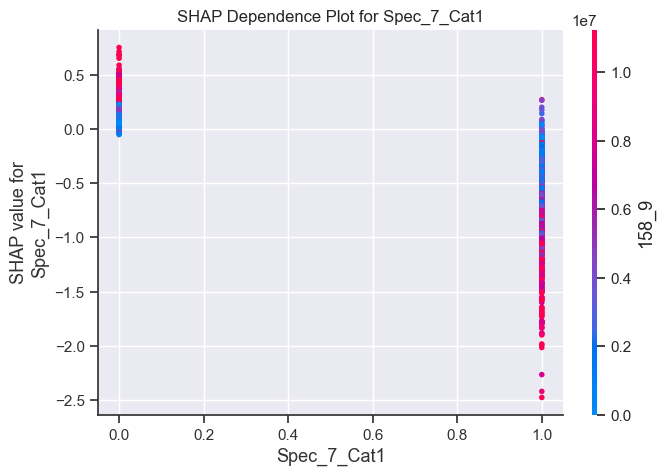

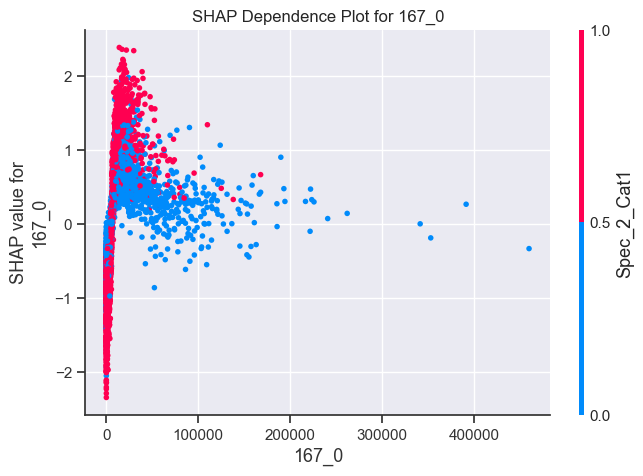

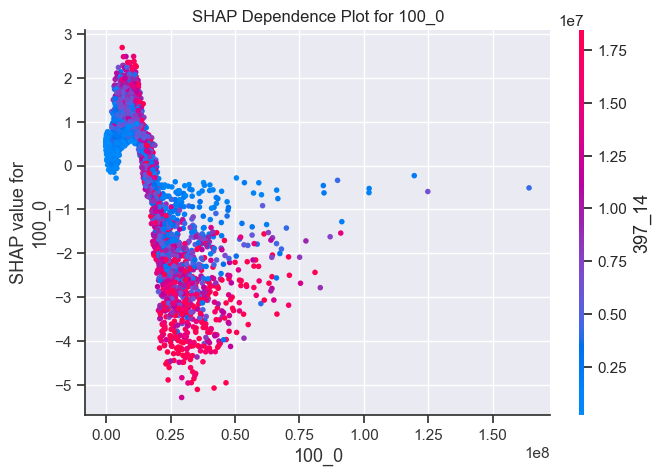

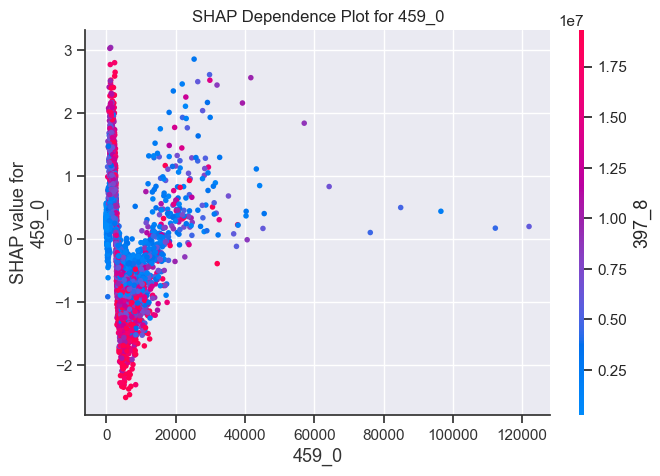

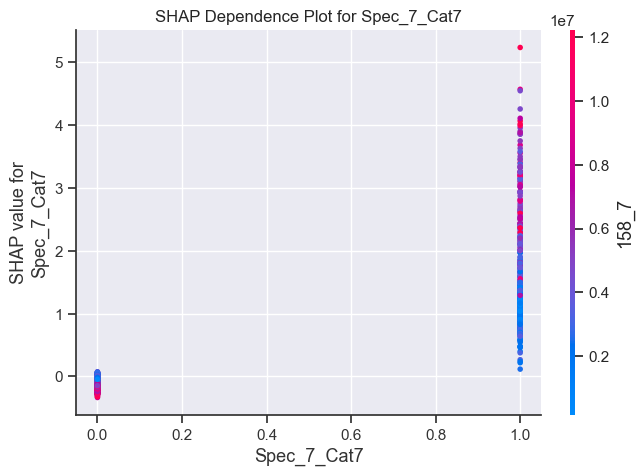

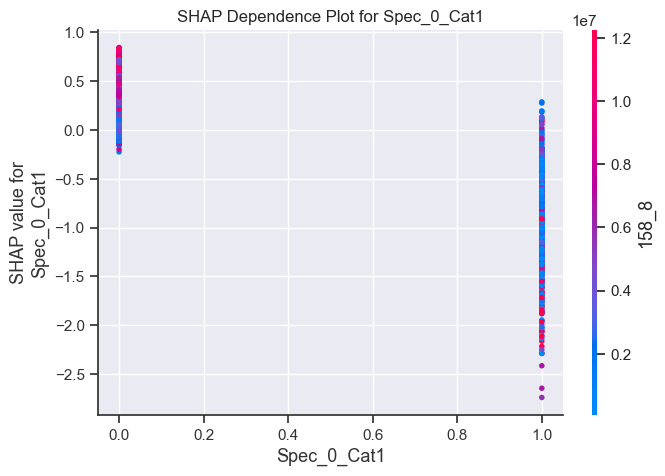

In [36]:
# Plot SHAP dependence plots for each feature
for feature_name in ['666_0', '837_0', '158_8', '309_0', '397_3', '167_3', '272_1', 'Spec_7_Cat1','167_0', '100_0', '459_0', 'Spec_7_Cat7', 'Spec_0_Cat1' ]:
    shap.dependence_plot(feature_name,shap_values, X_testt, show=False)
    plt.title(f'SHAP Dependence Plot for {feature_name}')
    plt.show()

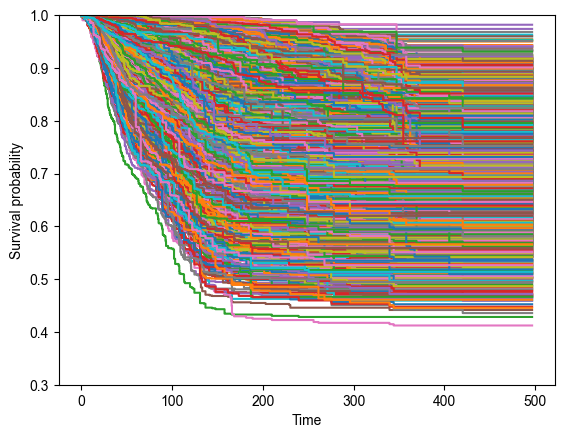

In [32]:
surv_funcs = rsf.predict_survival_function(test_X)
for fn in surv_funcs:
     plt.step(fn.x, fn(fn.x), where="post")

sns.set(rc = {'figure.figsize':(10,10)})
plt.ylabel("Survival probability")
plt.xlabel("Time")
plt.ylim(0.3, 1)
plt.show()

Indices of instances whose survival probability are above 90% within the first 250 time points: [2, 17, 20, 45, 68, 82, 93, 94, 101, 108, 109, 116, 121, 126, 139, 142, 148, 154, 157, 163, 173, 179, 182, 185, 187, 191, 203, 204, 206, 215, 218, 221, 237, 240, 248, 253, 257, 260, 264, 265, 271, 278, 280, 290, 291, 293, 294, 298, 322, 329, 333, 339, 342, 343, 347, 365, 387, 410, 415, 457, 462, 467, 474, 486, 489, 494, 498, 505, 514, 533, 534, 544, 547, 555, 556, 569, 578, 581, 588, 592, 597, 605, 607, 615, 620, 640, 647, 653, 676, 685, 691, 698, 705, 710, 715, 730, 731, 757, 794, 806, 810, 833, 839, 877, 882, 892, 901, 916, 934, 935, 936, 940, 949, 952, 972, 979, 985, 987, 996, 999, 1023, 1035, 1044, 1048, 1052, 1053, 1054, 1056, 1057, 1065, 1068, 1079, 1080, 1089, 1109, 1113, 1115, 1120, 1125, 1126, 1133, 1159, 1175, 1215, 1235, 1236, 1239, 1241, 1244, 1259, 1272, 1282, 1285, 1295, 1298, 1299, 1307, 1320, 1323, 1333, 1343, 1362, 1377, 1380, 1387, 1390, 1399, 1400, 1406, 1411, 1428, 1430, 

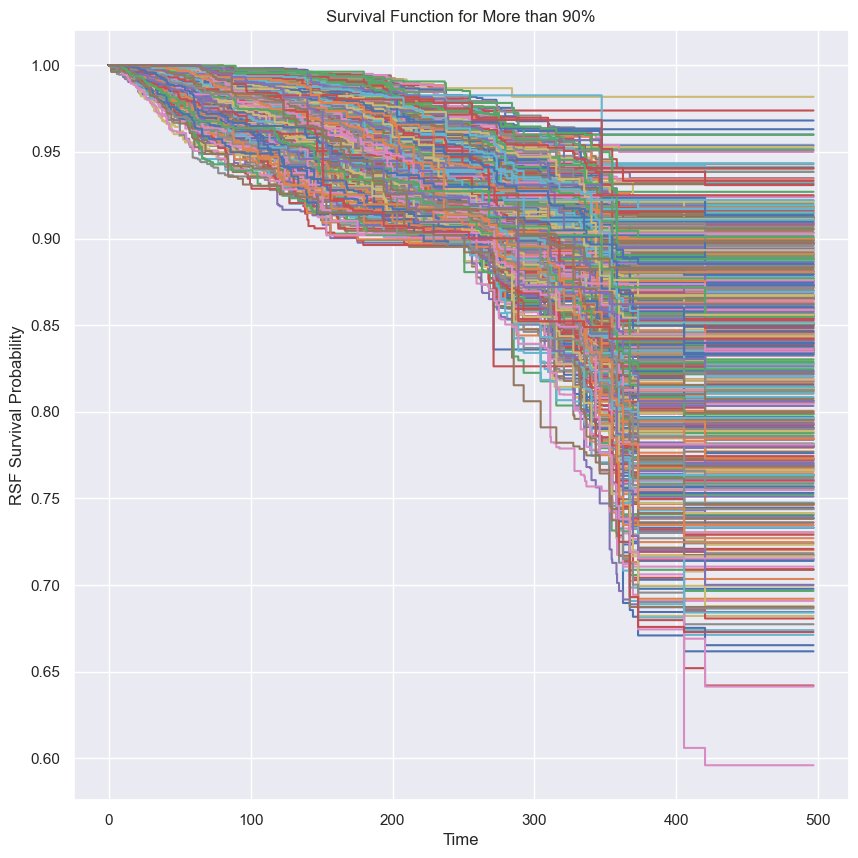

In [33]:
indices_fall_to_one = []
# Predict survival probabilities for all instances in the test set
surv_funcs = rsf.predict_survival_function(test_X)

# Iterate over each instance
for i, survival_func in enumerate(surv_funcs):
    survival_prob_at_250 = survival_func(250)
    survival_prob_at_250_rounded = round(survival_prob_at_250, 2)
    if survival_prob_at_250_rounded >= 0.9:
        indices_fall_to_one.append(i)

print("Indices of instances whose survival probability are above 90% within the first 250 time points:", indices_fall_to_one)
indices_to_plot = indices_fall_to_one  

# Iterate over the array of indices
for index in indices_to_plot:
    survival_func_to_plot = surv_funcs[index]
    plt.step(survival_func_to_plot.x, survival_func_to_plot.y, where="post", label=f"Instance {index}")
plt.xlabel("Time")
plt.ylabel("RSF Survival Probability")
plt.title("Survival Function for More than 90%")
sns.set(rc = {'figure.figsize':(20,20)})
#plt.legend()
plt.show()

Indices of instances whose survival probability are btw 90% and 70 % within the first 50 time points: [0, 6, 28, 30, 38, 50, 54, 55, 63, 91, 104, 147, 193, 220, 226, 234, 235, 269, 284, 288, 317, 399, 412, 416, 431, 443, 469, 472, 492, 496, 501, 516, 523, 546, 552, 558, 565, 571, 584, 590, 610, 639, 690, 692, 695, 779, 817, 822, 832, 837, 844, 847, 858, 868, 880, 899, 906, 912, 931, 970, 981, 983, 992, 1015, 1016, 1059, 1075, 1091, 1101, 1142, 1161, 1176, 1184, 1185, 1216, 1238, 1276, 1291, 1301, 1304, 1306, 1325, 1335, 1339, 1357, 1361, 1374, 1378, 1386, 1391, 1405, 1413, 1437, 1456, 1498, 1500, 1506, 1507, 1512, 1568, 1576, 1600, 1604, 1608, 1620, 1627, 1639, 1640, 1645, 1653, 1659, 1660, 1661, 1674, 1689, 1690, 1726, 1745, 1766, 1774, 1785, 1818, 1842, 1846, 1850, 1863, 1868, 1879, 1886, 1889, 1893, 1905, 1907, 1935, 1962, 2003, 2008, 2009, 2011, 2017, 2030, 2071, 2091, 2095, 2097, 2147, 2158, 2167, 2174, 2176, 2204, 2211, 2220, 2231, 2251, 2271, 2290, 2308, 2340, 2361, 2377, 2393, 

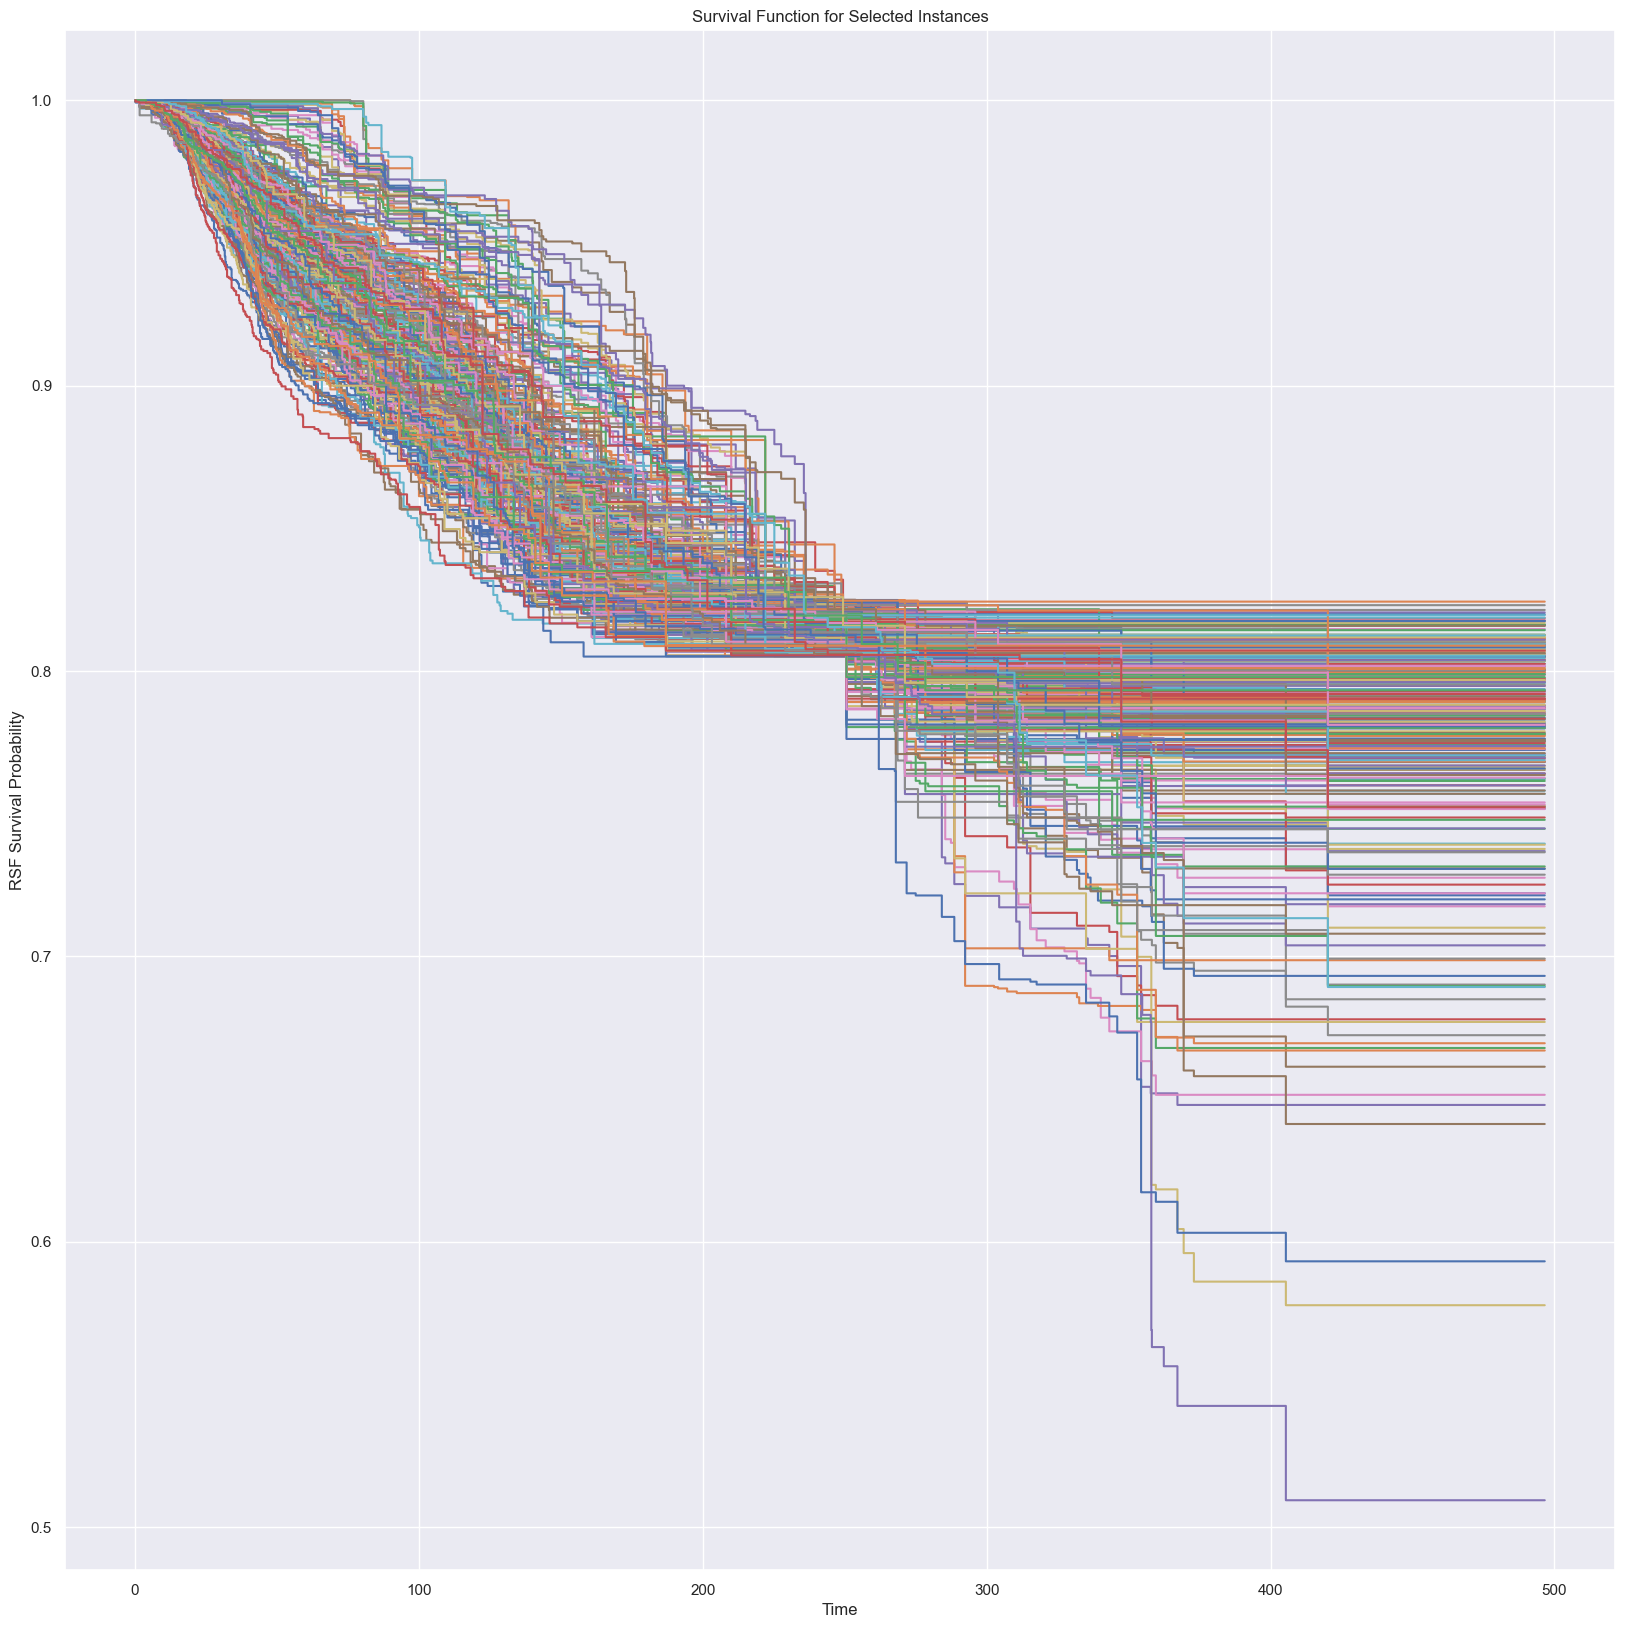

294


In [34]:
indices_eighty_to_sixty = []
# Predict survival probabilities for all instances in the test set
surv_funcs = rsf.predict_survival_function(test_X)

# Iterate over each instance
for i, survival_func in enumerate(surv_funcs):
    survival_prob_at_50 = survival_func(250)
    survival_prob_at_50_rounded = round(survival_prob_at_50, 2)
    if (survival_prob_at_50_rounded > 0.8) & (survival_prob_at_50_rounded <= 0.82) :
        indices_eighty_to_sixty.append(i)

print("Indices of instances whose survival probability are btw 90% and 70 % within the first 50 time points:", indices_eighty_to_sixty)
indices_to_plot = indices_eighty_to_sixty  

# Iterate over the array of indices
for index in indices_to_plot:
    # Get the survival function for the selected index
    survival_func_to_plot = surv_funcs[index]
    # Plot the survival function
    plt.step(survival_func_to_plot.x, survival_func_to_plot.y, where="post", label=f"Instance {index}")
plt.xlabel("Time")
plt.ylabel("RSF Survival Probability")
plt.title("Survival Function for Selected Instances")
#plt.legend()
plt.show()

print(len(indices_eighty_to_sixty))

Indices of instances whose survival probability are bellow 60% within the first 50 time points: [1, 8, 9, 11, 12, 13, 18, 22, 26, 27, 29, 33, 34, 39, 41, 42, 44, 53, 62, 64, 66, 67, 69, 71, 76, 77, 79, 85, 86, 90, 103, 105, 106, 110, 113, 114, 130, 132, 133, 134, 138, 150, 160, 161, 162, 164, 165, 169, 170, 172, 174, 181, 186, 192, 197, 198, 205, 208, 209, 217, 219, 227, 236, 242, 243, 244, 246, 254, 267, 274, 276, 281, 285, 302, 310, 312, 314, 315, 319, 321, 323, 324, 327, 331, 340, 341, 344, 350, 352, 354, 355, 356, 359, 362, 367, 374, 375, 377, 380, 381, 382, 388, 392, 393, 397, 400, 401, 404, 407, 413, 417, 418, 421, 428, 439, 440, 442, 445, 447, 448, 450, 451, 456, 463, 470, 481, 483, 490, 491, 497, 499, 500, 517, 521, 524, 526, 532, 535, 545, 548, 549, 554, 560, 561, 568, 576, 577, 585, 594, 599, 604, 606, 608, 611, 616, 617, 623, 627, 628, 629, 637, 638, 646, 652, 654, 657, 658, 659, 664, 666, 667, 669, 670, 681, 688, 702, 703, 714, 716, 719, 723, 725, 727, 734, 741, 743, 745, 7

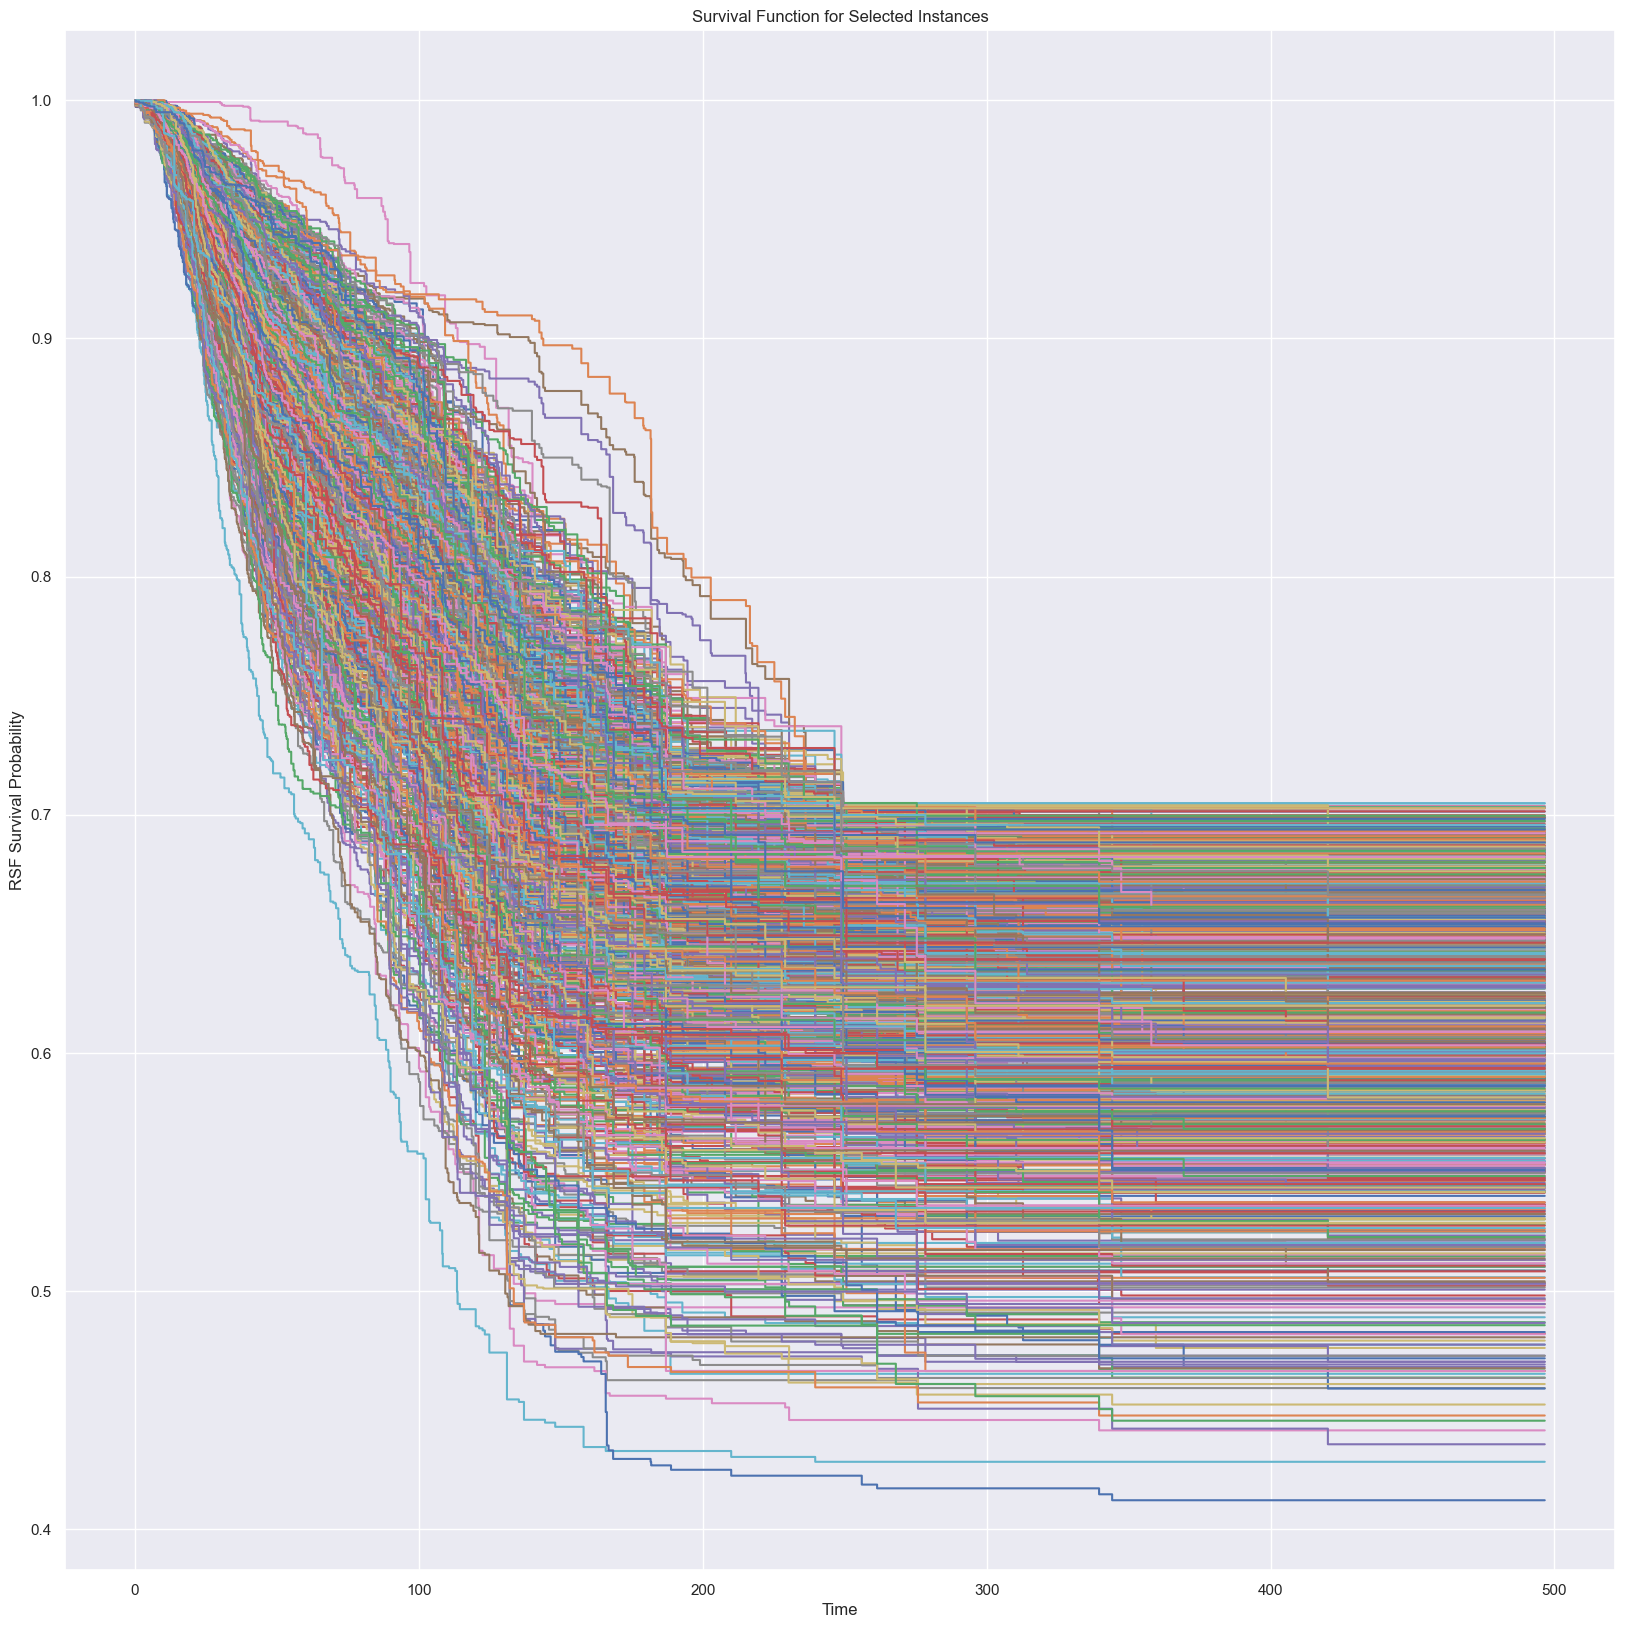

1231


In [35]:
indices_fall_to_sixty = []
surv_funcs = rsf.predict_survival_function(test_X)

# Iterate over each instance
for i, survival_func in enumerate(surv_funcs):
    survival_prob_at_50 = survival_func(250)
    survival_prob_at_50_rounded = round(survival_prob_at_50, 2)
    if survival_prob_at_50_rounded <= 0.7:
        indices_fall_to_sixty.append(i)

print("Indices of instances whose survival probability are bellow 60% within the first 50 time points:", indices_fall_to_sixty)
indices_to_plot = indices_fall_to_sixty 
for index in indices_to_plot:
    survival_func_to_plot = surv_funcs[index]
    plt.step(survival_func_to_plot.x, survival_func_to_plot.y, where="post", label=f"Instance {index}")
plt.xlabel("Time")
plt.ylabel("RSF Survival Probability")
plt.title("Survival Function for Selected Instances")
#plt.legend()
plt.show()
print(len(indices_fall_to_sixty))

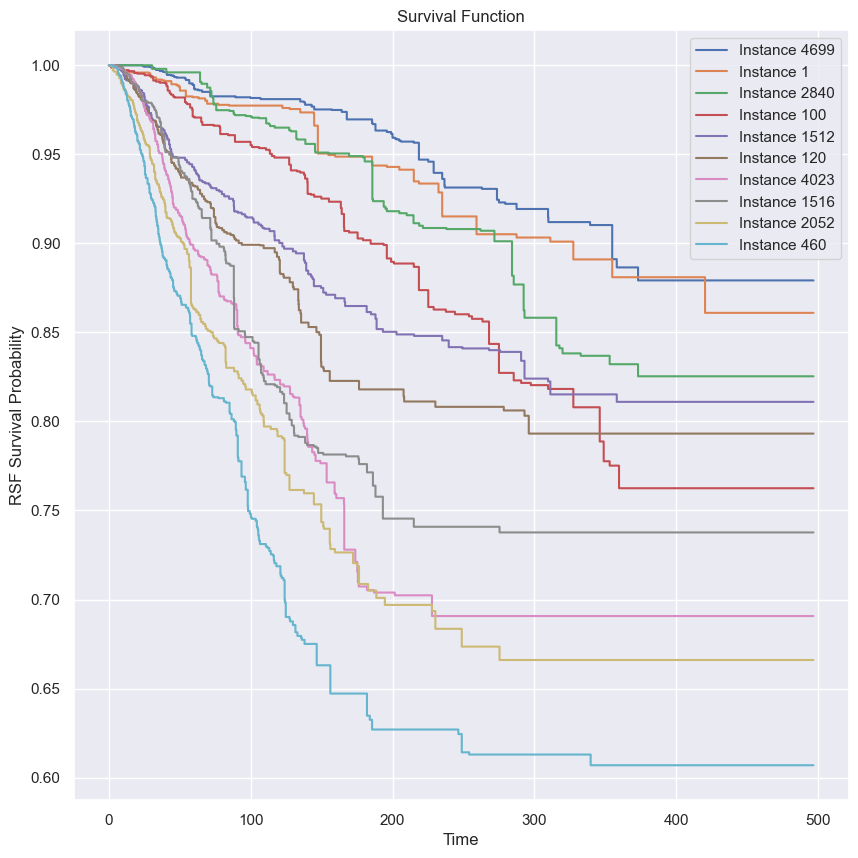

In [73]:

indices = [4699, 1, 2840, 100, 1512,  120,  4023, 1516, 2052, 460  ]

for index in indices:
    survival_func_to_plot = surv_funcs[index]
    plt.step(survival_func_to_plot.x, survival_func_to_plot.y, where="post", label=f"Instance {index}")

plt.xlabel("Time")
plt.ylabel("RSF Survival Probability")
plt.title("Survival Function")

sns.set(rc={'figure.figsize': (10, 10)})
plt.legend()
plt.show()


      vehicle_id  length_of_study_time_step  in_study_repair  time_step  \
4699        6736                      181.6                0      113.2   

         171_0  666_0       427_0  837_0   167_0      167_1  ...  Spec_7_Cat1  \
4699  125820.0  953.0  12017281.0   16.0  3795.0  8520616.0  ...            0   

      Spec_7_Cat2  Spec_7_Cat3  Spec_7_Cat4  Spec_7_Cat5  Spec_7_Cat6  \
4699            1            0            0            0            0   

      Spec_7_Cat7  Spec_7_Cat8  status   RUL  
4699            0            0   False  68.4  

[1 rows x 201 columns]


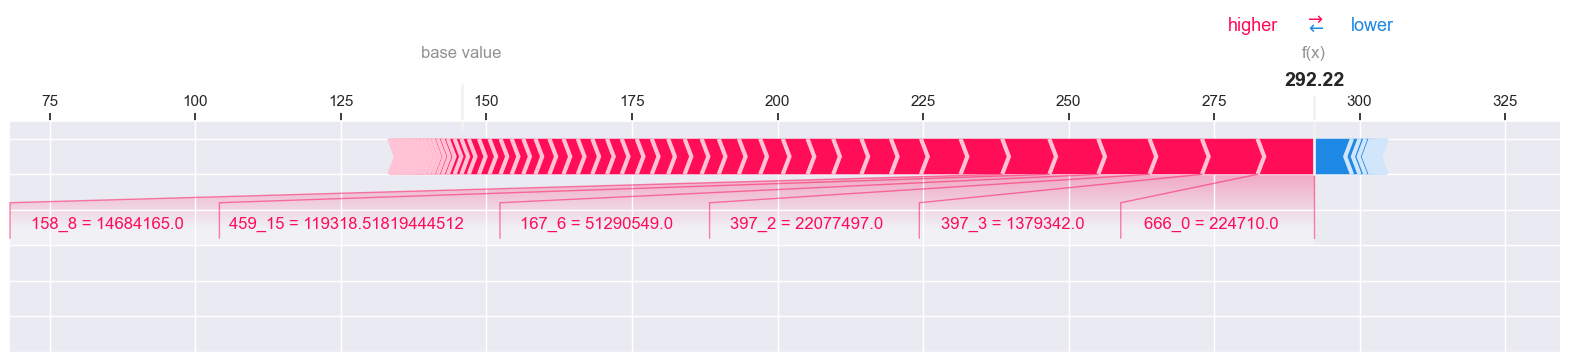

In [39]:
print(dataset_ffil[dataset_ffil.index == 4699])
instance_index = 4699
instance = X_testt.iloc[instance_index]  # Get the instance from the test set
    
# Calculate SHAP values for the chosen instance
shap_values_instance = shap_values[instance_index]
expected_value1 = explainer.expected_value
shap.initjs()
# Plot local SHAP force plot for the chosen instance
shap.force_plot(expected_value1, shap_values_instance, instance , matplotlib=True)

In [40]:
print(dataset_ffil[dataset_ffil.index == 460])
instance_index = 460
instance = X_testt.iloc[instance_index]  # Get the instance from the test set
    
# Calculate SHAP values for the chosen instance
shap_values_instance = shap_values[instance_index]
expected_value1 = explainer.expected_value
shap.initjs()
# Plot local SHAP force plot for the chosen instance
shap.force_plot(expected_value1, shap_values_instance, instance , matplotlib=True)

     vehicle_id  length_of_study_time_step  in_study_repair  time_step  \
460         646                      351.4                1      326.0   

         171_0     666_0        427_0    837_0    167_0       167_1  ...  \
460  9454125.0  279666.0  325825654.0  64083.0  50876.0  22774704.0  ...   

     Spec_7_Cat1  Spec_7_Cat2  Spec_7_Cat3  Spec_7_Cat4  Spec_7_Cat5  \
460            0            0            0            0            0   

     Spec_7_Cat6  Spec_7_Cat7  Spec_7_Cat8  status   RUL  
460            0            0            0    True  25.4  

[1 rows x 201 columns]


In [41]:
print(dataset_ffil[dataset_ffil.index == 120])
instance_index = 120
instance = X_testt.iloc[instance_index]  # Get the instance from the test set
    
# Calculate SHAP values for the chosen instance
shap_values_instance = shap_values[instance_index]
expected_value1 = explainer.expected_value
shap.initjs()
# Plot local SHAP force plot for the chosen instance
shap.force_plot(expected_value1, shap_values_instance, instance , matplotlib=True)

     vehicle_id  length_of_study_time_step  in_study_repair  time_step  \
120         163                      488.8                0      186.8   

         171_0     666_0        427_0    837_0     167_0      167_1  ...  \
120  5632065.0  466368.0  208458916.0  64268.0  159818.0  8316592.0  ...   

     Spec_7_Cat1  Spec_7_Cat2  Spec_7_Cat3  Spec_7_Cat4  Spec_7_Cat5  \
120            0            0            0            0            0   

     Spec_7_Cat6  Spec_7_Cat7  Spec_7_Cat8  status    RUL  
120            0            0            0   False  302.0  

[1 rows x 201 columns]
